In [6]:
import numpy as np 
import matplotlib.pyplot as plt 
from math import sqrt
from matplotlib import animation, rc
from IPython.display import HTML

# O problema dos N-corpos

O objetivo deste trabalho é resolver o problema dos N-corpos numericamente, especificamente o problema dos 3 corpos com os métodos Runge-Kuta 4 e de Verlet.

Dada a segunda lei de Newton e a lei da gravitação universal, temos a seguinte equação:
$$ m_i \frac{d^2 r_i}{dt^2} = \sum_{i \neq j} F_{i,j} $$

com $$F_{i,j} = G \frac{m_i m_j}{||r_i - r_j||^2} $$

o que nos dá:

$$\Rightarrow \frac{d^2 r_i}{dt^2}  =\sum_{i \neq j} G \frac{m_j}{||r_i - r_j||^3} (r_i - r_j)$$

Onde $r_i$ representa a posição de cada corpo $i$ num determinado instante de tempo.

Para resolver com os métodos indicados acima, vamos transformar a equação de segunda ordem acima em um sistema de segunda ordem, fazendo $v_i = \frac{dr_i}{dt}$:

$$
\begin{cases}
\frac{dr_i}{dt} = v_i \\
\frac{d v_i}{dt} = \sum_{i \neq j} G \frac{m_j r_{ij}}{||r_{ij}||^3}
\end{cases}
$$

Antes de implementar os métodos, criei uma classe para representar os corpos envolvidos no problema. Eles tem como attributos principais:

- massa
- posição inicial
- velocidade inicial 
- aceleração, que é atualizada ao longo da simulação
- `position_tracker`, que armazena as posições do corpo durante a simulação






In [7]:
class Body():
  def __init__(self,mass,position,velocity):
    '''Creates a Body instance.
    Atributes:
    - mass (scalar)
    - initial position (array)
    - initial speed (array)
    - accl/acceleration (array-like): to be updated during simulation
    - pos_tracker (array-like): contains every position occupied by i-body during simulation
    - v_tracker (array-like): tracks speed during simulation
    - sim_status (bool): indicates whether a body is undergoing simulation or not
    '''
    self.mass = mass
    self.initial_pos = self.current_pos = position
    self.initial_v = self.current_v = velocity
    self.accl = 0 
    self.sim_status = False
    self.pos_tracker = [self.initial_pos]
    self.v_tracker = [self.initial_v]
    self.status()

  def status(self):
    '''Function that displays a body's current status, that includes all physical
    parameters that we can calculate.'''
    print('------------- Current Status --------------')
    print(f'Simulation Status {self.sim_status}')
    print(f'Current Speed: {self.current_v}')
    print(f'Current Position: {self.current_pos}')
    print(f'Current Acceleration: {self.accl}')
    print(f'Linear Momentum: {self.momentum()}')
    print(f'Kinectic Energy: {self.current_kin()}')
    print('-------------------------------------------')

  def momentum(self):
    '''Returns body's linear momentum given its current parameters.'''
    return self.mass * self.current_v

  def current_kin(self):
    '''Method that returns a body's current kinectic energy.'''
    k = self.mass/2 * np.linalg.norm(self.current_speed())
    return k

  def start_sim(self,restart = True):
    '''Function that creates storage variables for speed and position to be used
    for the n-body simulation.'''
    if restart == True:
      self.pos_tracker = [self.initial_pos]
      self.v_tracker = [self.initial_v]
    self.sim_status = True

  def end_sim(self,restart = False):
    '''Function that ends simulations. Returns an array containing the time evolution
    of each coordinate during simulation.
    - restart (parameter): to be used only when the data collected can be imediatelly 
    erased.
    '''
    if restart == True:
      self.pos_tracker = [self.intial_pos]
      self.v_tracker = [self.initial_v]
    self.sim_status = False
    #print(np.array(self.pos_tracker).shape)
    return np.array(self.pos_tracker).transpose()

  def update_speed(self,new_v):
    '''Method used exclusively to update the body's speed. Also adds current speed
    to tracker.'''
    self.v_tracker.append(new_v)
    self.current_v = self.v_tracker[-1]

  def update_position(self,new_p):
    '''Method used to update body's current position and store it in tracker.'''
    self.pos_tracker.append(new_p)
    self.current_pos = self.pos_tracker[-1]
  
  def update_accl(self,new_a):
    '''Method used to update body's current acceleration.
    This calculation cannot be made solely with one body information, therefore 
    this class does not contain a method for it.
    '''
    self.accl = new_a

  def current_speed(self):
    '''Function that returns current speed for the body.'''
    return self.current_v 

  def current_postiion(self):
    '''Returns the body's current position (array-like).'''
    return self.current_pos

Criada a classe dos corpos, podemos criar outra classe para as simulações, que deverão conter ambos os métodos escolhidos como métodos, assim como as funções necessárias para que o problema seja executado.

Recebe:
- `Corpos`: lista com todos os corpos envolvidos no problema, instâncias da classe acima;
- `ending_time`: tempo final da simulação;
- `N`: número de passos a serem calculados;
- `method`(opcional): método escolhido para solução ('RK4' ou 'verlet'), 'RK4' como padrão;
- `G` (opcional): valor para a constante universal de gravitação, por padrão `6.674e-11`




In [52]:
class Simulation():
  def __init__(self,bodies,ending_time,N, method = 'RK4', G = 6.6743e-11):
    '''Creates an instance to the Simulation class.
    Parameters:
    - bodies: list of bodies (Body instanse);
    - ending_time: final time of the simulation;
    - N: number of steps in the solution;
    - method: numerical method chosen to solve the problem
    - G: value for the gravitation constant
    
    Atributes:
    - bodies (list)
    - ending_time (float)
    - n_steps (int)
    - method (string)
    - body_position (array) - stores current position for each body 
    - body_speed (array) - stores current speed of each body
    '''
    self.bodies = bodies # list
    self.N_bodies = len(self.bodies) # int
    self.ending_time = ending_time # scalar, float 
    self.n_steps = N # int
    self.step = ending_time/N
    self.method = method # string
    self.body_position = []
    self.body_speed = []
    self.body_accl = []
    self.G = G # float constant

  def get_speed(self):
    '''Function that gets current speed of each body in simulation.
    Updates body_speed to latest.'''
    self.body_speed = []
    for b in self.bodies:
      self.body_speed.append(b.current_v)
    return np.array(self.body_speed) # array-like, shape = (N,n) in which N is the number of bodies and n is the dimention number (expected is 2)
  
  def get_position(self):
    '''Function that gets current position of each body in simulation.'''
    self.body_position = [] # restart variable
    for b in self.bodies:
        self.body_position.append(b.current_pos)
    return np.array(self.body_position) # (N,n) array-like 
  
  def dist(self,c1,c2,t):
    '''Function that calculates the distance between two bodies given the body itself
    or the position of each body.
    This distinction has to be made with parameter t (string)'''
    if t == 'body':
      n1, n2 = len(c1.current_pos), len(c2.current_pos)
      if n1 != n2:
        raise ValueError("The given objects have different dimentions.")
      d = 0
      for i in range(n1):
        d += (c1.current_pos[i] - c2.current_pos[i])**2
      if d == 0:
        raise ValueError("Bodies can't have the same position.")

    if t == 'array':
      n1, n2 = len(c1), len(c2)
      if n1 != n2:
        raise ValueError("The given objects have different dimentions.")
      d = 0
      for i in range(n1):
        d += (c1[i] - c2[i])**2
      if d == 0:
        raise ValueError("Bodies can't have the same position.")
    return np.sqrt(d)

  def F_grav(self,c1,c2,updater = None):
    '''Calculates the gravitational force between two bodies.
    Parameters;
    - c1, c2: bodies involved
    - updater: parameter that guarantees RK4's functionality. when different from
      None, is equal to the 'half step' taken in each RK4 step.
      '''
    if updater != None:
      c1_updated_pos = c1.current_pos + updater[0]
      c2_updated_pos = c2.current_pos + updater[1]
      F = self.G*c1.mass*c2.mass*(c1_updated_pos - c2_updated_pos)/(self.dist(c1_updated_pos,c2_updated_pos, t = 'array')**3)
    else:
      F = self.G*c1.mass*c2.mass*(c1.current_pos - c2.current_pos)/(self.dist(c1,c2, t = 'body')**3)
    #print(F)
    return F 

  def get_accl(self, updater = None):
    '''Calculates acceleration in a given time for each body in simulation.
    Returns an array containing (x,y) acceleration of each body.'''
    self.body_accl = []
    for i in range(self.N_bodies):
      accl = np.zeros(2) # current acceleration for i body 
      # 2D vector (x,y)
      for j in range(self.N_bodies):
        b1 = self.bodies[i]
        b2 = self.bodies[j]
        if i == j:
          continue
        if updater is not None:
          up = (updater[i],updater[j])
          a = self.F_grav(b1,b2,up)/b1.mass # array-like (x,y)
        else:
          a = self.F_grav(b1,b2)/b1.mass # array-like (x,y)
        accl += -a # signal correction so that acceleration points in the directio opposite to r_ij
      self.body_accl.append(np.array(accl))
    return np.array(self.body_accl)

  def start(self, animate = False):
    '''Main function. Simulates the n-body problem given the method chosen in the 
    instance. Returns an array with the position for each body in every given time 
    in simulation. Also plots the orbits.'''
    h = self.ending_time/self.n_steps # step size 
    time = np.arange(0,self.ending_time,step=h)
    
    for b in self.bodies:
      b.start_sim()
    
    if self.method == 'RK4':
      # start the rk4 algorithm
      for t in time:
        # should have an update for speed and position simultaneously
        # accl steps use position but update speed
        # speed steps use speed but update position
        v = self.get_speed() 
        p = self.get_position() # both array like, containing N n-dimentional vectors
        # first step 
        k1_accl = self.get_accl()
        k1_speed = v
        # second step 
        k2_accl = self.get_accl(updater = (h/2)*k1_speed)
        k2_speed = v + (h/2)*k1_accl
        # third step
        k3_accl = self.get_accl(updater = (h/2)*k2_speed)
        k3_speed = v + (h/2)*k2_accl
        # fourth step
        k4_accl = self.get_accl(updater = h*k3_speed)
        k4_speed = v + h*k3_accl

        v_next = v + (h/6)*(k1_accl + 2*k2_accl + 2*k3_accl + k4_accl)
        p_next = p + (h/6)*(k1_speed + 2*k2_speed + 2*k3_speed + k4_speed)

        for i in range(self.N_bodies):
          self.bodies[i].update_speed(v_next[i])
          self.bodies[i].update_position(p_next[i])
    
    if self.method == 'verlet':
      # 1st we shall calculate the solution for t_1
      for t in time:
        v = self.get_speed()
        p = self.get_position()
        a = self.get_accl()

        p_next = p + h*v + h*h*a/2
        for i in range(self.N_bodies):
          self.bodies[i].update_position(p_next[i])
        
        a_next = self.get_accl()
        v_next = v + (a_next + a)*h/2
        for i in range(self.N_bodies):
          self.bodies[i].update_speed(v_next[i])

    ans = [b.end_sim() for b in self.bodies]
    if animate == False:
      self.plot(ans,f'Solução {self.N_bodies}-corpos')
    if animate == True:
      self.animate(ans)
    return ans

  def plot(self,data,title,figsize=(8,10)):
    '''Method to plot the solution for the simulation.'''
    plt.figure(figsize = figsize)
    for i in range(self.N_bodies):
      plt.plot(data[i][0],data[i][1],label=f'Body {i+1}')
      plt.scatter(data[i][0][0],data[i][1][0])
    
    plt.grid()
    plt.legend()
    plt.title(title)

  def animate(self,data,figsize=(8,10)):
    '''Funtion that creates animation for the current simulation.
    Only works for the 3-body problem.'''
    fig, ax = plt.subplots(figsize=figsize)
    
    if self.N_bodies == 3:
      xmin = min(np.amin(data[0][0]),np.amin(data[1][0]),np.amin(data[2][0]))
      xmax = max(np.amax(data[0][0]),np.amax(data[1][0]),np.amax(data[2][0]))
      ymin = min(np.amin(data[0][1]),np.amin(data[1][1]),np.amin(data[2][1]))
      ymax = max(np.amax(data[0][1]),np.amax(data[1][1]),np.amax(data[2][1]))
    else:
      xmin = min(np.amin(data[0][0]),np.amin(data[1][0]))
      xmax = max(np.amax(data[0][0]),np.amax(data[1][0]))
      ymin = min(np.amin(data[0][1]),np.amin(data[1][1]))
      ymax = max(np.amax(data[0][1]),np.amax(data[1][1]))

    ax.set_xlim((xmin, xmax))
    ax.set_ylim((ymin,ymax))
    ax.grid()

    line1, = ax.plot([],[])
    line2, = ax.plot([],[])
    if self.N_bodies == 3:
      line3, = ax.plot([],[],)

    def animation_func(i):
      line1.set_data(data[0][0][:i], data[0][1][:i])
      line2.set_data(data[1][0][:i], data[1][1][:i])
      if self.N_bodies == 3:
        line3.set_data(data[2][0][:i], data[2][1][:i])
        return (line1,line2,line3,)
      return (line1,line2,)

    anim = animation.FuncAnimation(fig,animation_func ,frames=self.n_steps +1,interval = 20,blit=True)
    return HTML(anim.to_html5_video())

Feito isso, vamos definir os parâmetros para a simulação. 

Para facilitar as contas, vamos considerar a massa de todos os corpos igual e, também, a constante universal de gravitação como 1.

In [53]:
# initial conditions
# postion
r1 = np.array([-1,0])
r2 = -r1
r3 = np.array([0,0])
# speed
v1 = np.array([0.322184765624991, 0.647989160156249])
v2 = v1
v3 = -2*v1
# mass
m1 = m2 = m3 = 1

N = 1000
tf = 17.15
G = 1

In [54]:
# creating bodies 
Corpo1 = Body(m1,r1,v1)
Corpo2 = Body(m2,r2,v2)
Corpo3 = Body(m3,r3,v3)

corpos = [Corpo1, Corpo2, Corpo3]

------------- Current Status --------------
Simulation Status False
Current Speed: [0.32218477 0.64798916]
Current Position: [-1  0]
Current Acceleration: 0
Linear Momentum: [0.32218477 0.64798916]
Kinectic Energy: 0.3618331711164799
-------------------------------------------
------------- Current Status --------------
Simulation Status False
Current Speed: [0.32218477 0.64798916]
Current Position: [1 0]
Current Acceleration: 0
Linear Momentum: [0.32218477 0.64798916]
Kinectic Energy: 0.3618331711164799
-------------------------------------------
------------- Current Status --------------
Simulation Status False
Current Speed: [-0.64436953 -1.29597832]
Current Position: [0 0]
Current Acceleration: 0
Linear Momentum: [-0.64436953 -1.29597832]
Kinectic Energy: 0.7236663422329598
-------------------------------------------


In [55]:
# creating simulations
threeBody_rk4 = Simulation(corpos,tf,N,'RK4',G=G)
threeBody_verlet = Simulation(corpos,tf,N,'verlet',G=G)

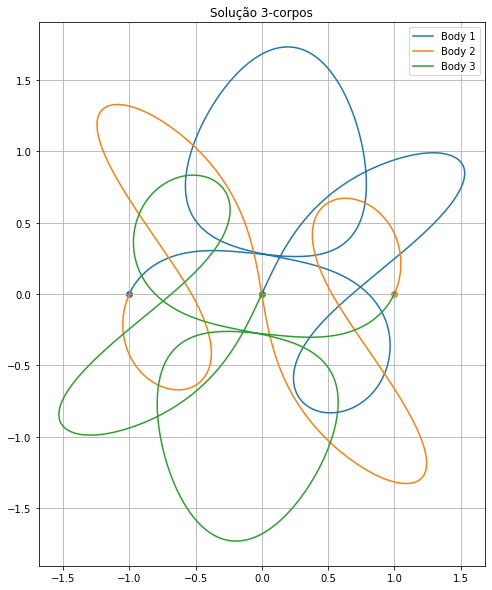

In [56]:
c = threeBody_rk4.start()

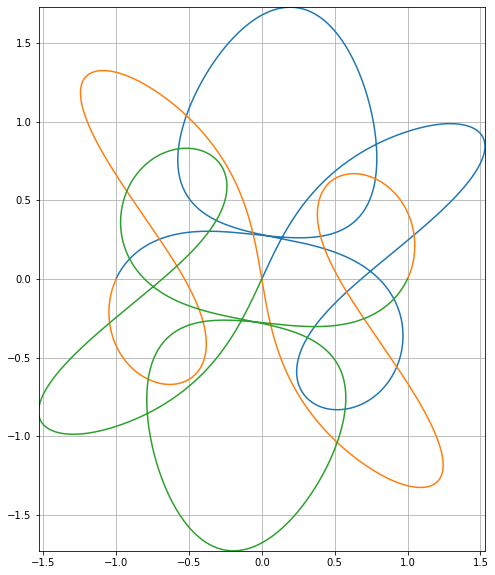

In [57]:
threeBody_rk4.animate(c)

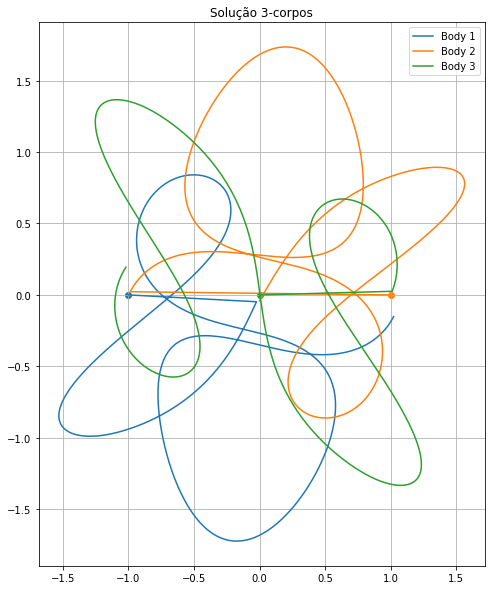

In [58]:
v = threeBody_verlet.start()

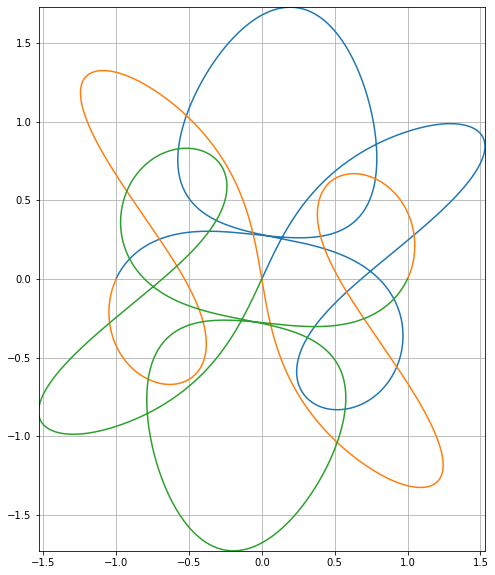

In [59]:
threeBody_verlet.animate(c)